In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
directory = '../../cc3/rice_data/ecg_ppg_final/'
yield_ecg = []
yield_ppg = []
for f in os.listdir(directory):
    if f[-1]!='p':
        continue
    data1 = pickle.load(open(directory+f,'rb'))[0]
    for i,data in data1.groupby('hand',as_index=False): 
        data_days = [df for i,df in data.groupby(['user','day'],as_index=False) if df.shape[0]>0]
        for df in data_days:
            if df['stress_likelihood_ppg'].dropna().shape[0]>0:
                yield_ppg.append(df['stress_likelihood_ppg'].dropna().shape[0])
            if df['stress_likelihood_ecg'].dropna().shape[0]>0:
                yield_ecg.append(df['stress_likelihood_ecg'].dropna().shape[0])

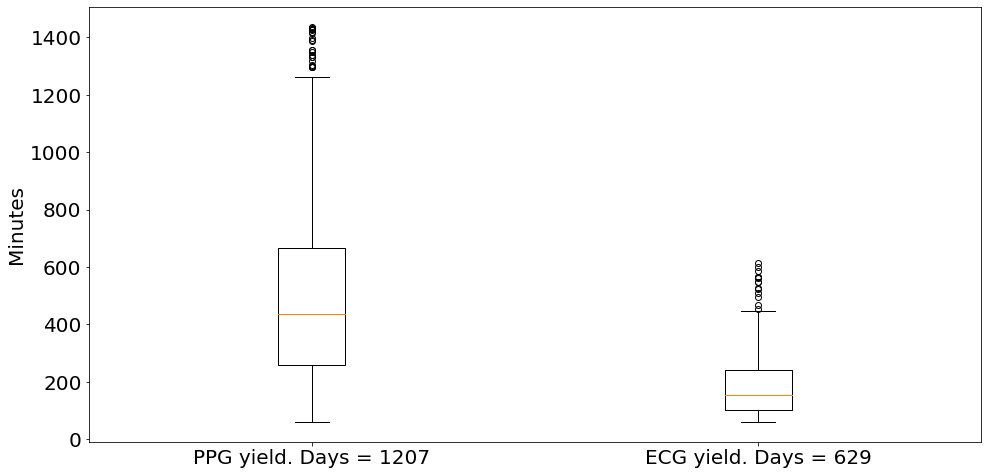

In [2]:
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(16,8))
plt.boxplot([yield_ppg,yield_ecg])
plt.xticks([1,2],['PPG yield. Days = '+str(len(yield_ppg)),'ECG yield. Days = '+str(len(yield_ecg))])
plt.ylabel('Minutes')
plt.show()

In [3]:
from sklearn.metrics import r2_score
directory = '../../cc3/rice_data/ecg_ppg_final/'
all_scores = []
for f in os.listdir(directory):
    if f[-1]!='p':
        continue
    data1 = pickle.load(open(directory+f,'rb'))[0]
    for i,data in data1.groupby('hand',as_index=False): 
        data_days = [df[['stress_likelihood_ecg',
                         'stress_likelihood_ppg',
                         'stress_likelihood_ppg_qual']].dropna() for i,df in data.groupby(['user','day'],as_index=False) if df.shape[0]>0]
        scores = [np.array([r2_score(df['stress_likelihood_ecg'],df['stress_likelihood_ppg']), \
                            r2_score(df['stress_likelihood_ecg'],df['stress_likelihood_ppg_qual'])]) for df in data_days if df.shape[0]>60]
        all_scores.extend(scores)

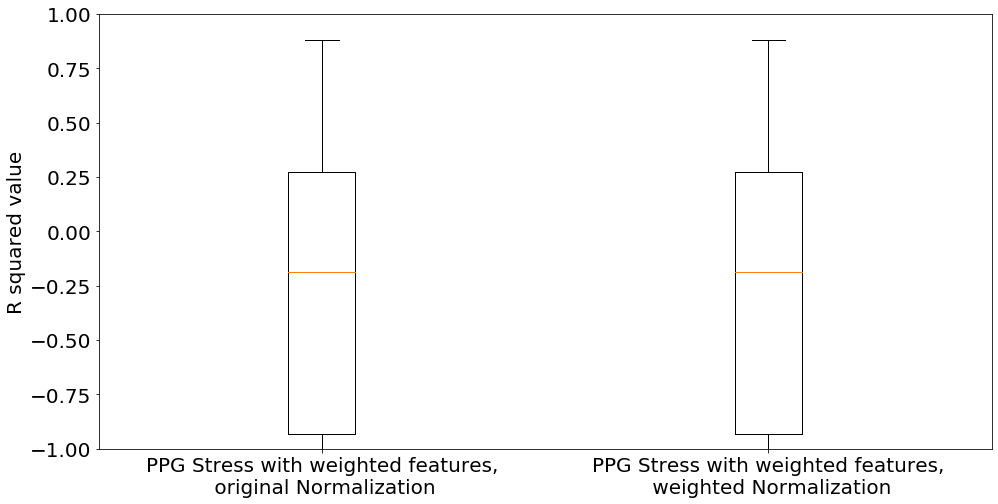

In [4]:
all_scores = np.array(all_scores)
plt.figure(figsize=(16,8))
plt.boxplot(all_scores)
plt.xticks([1,2],['PPG Stress with weighted features,\n original Normalization',
                 'PPG Stress with weighted features,\n weighted Normalization'])
plt.ylabel('R squared value')
plt.ylim([-1,1])
plt.show()

In [6]:
from sklearn.metrics import r2_score
import pickle
import numpy as np
from joblib import Parallel,delayed
import os
directory = '../../cc3/rice_data/ecg_ppg_final/'
all_scores_1 = []
all_scores_2 = []
all_yields = []
data_col = []
def get_data(directory,f):
    return pickle.load(open(directory+f,'rb'))[0]
data_col = Parallel(n_jobs=30,verbose=3)(delayed(get_data)(directory,f) for f in os.listdir(directory) if f[-1]=='p')

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  18 out of  57 | elapsed:    7.6s remaining:   16.4s
[Parallel(n_jobs=30)]: Done  38 out of  57 | elapsed:   25.4s remaining:   12.7s
[Parallel(n_jobs=30)]: Done  57 out of  57 | elapsed:   47.3s finished


In [9]:
import pandas as pd
df = pd.concat(data_col)

In [13]:
df['quality_mag_final'] = df['quality_mag'].apply(lambda a:(a*99.99)//10)

In [14]:
all_dfs = [dft for i,dft in df.groupby('quality_mag_final',as_index=False)]

In [ ]:
import numpy as np
def balanced_sample_maker(X, y, sample_size=200, random_seed=None):
    """ return a balanced data set by sampling all classes with sample_size 
        current version is developed on assumption that the positive
        class is the minority.

    Parameters:
    ===========
    X: {numpy.ndarrray}
    y: {numpy.ndarray}
    """
    uniq_levels = np.unique(y)
    uniq_counts = {level: sum(y == level) for level in uniq_levels}

    if not random_seed is None:
        np.random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        if not obs_idx:
            continue
        groupby_levels[level] = obs_idx
    # oversampling on observations of each label
    balanced_copy_idx = []
    for gb_level, gb_idx in groupby_levels.items():
        over_sample_idx = np.random.choice(np.array(gb_idx), size=sample_size, replace=True).tolist()
        balanced_copy_idx+=over_sample_idx
#     np.random.shuffle(balanced_copy_idx)
#     print(X[balanced_copy_idx, :])
    return (X[balanced_copy_idx, :], y[balanced_copy_idx], balanced_copy_idx)


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.rcParams.update({'font.size':20})
for i,a in enumerate(all_dfs):
    this_df = pd.concat([b.dropna() for i,b in a.groupby(['user','day'],as_index=False) if b[['stress_likelihood_ecg','stress_likelihood_ppg','stress_likelihood_ppg_qual']].dropna().shape[0]>0])
    X = this_df[['stress_likelihood_ecg','stress_likelihood_ppg','stress_likelihood_ppg_qual','quality_mag_final']].values
    y = np.round(this_df.stress_likelihood_ppg_qual.values*100)/200
    X,y,r= balanced_sample_maker(X, y, sample_size=200, random_seed=None)
    this_df =- pd.DataFrame(X*-1,columns=['stress_likelihood_ecg','stress_likelihood_ppg','stress_likelihood_ppg_qual','quality_mag_final'])
#     print(this_df)
    sns.set(style="ticks")
    this_df['STRESS LIKELIHOOD ECG'] = this_df['stress_likelihood_ecg']
    this_df['STRESS LIKELIHOOD PPG'] = this_df['stress_likelihood_ppg_qual']
    g = sns.jointplot(x='STRESS LIKELIHOOD ECG', y='STRESS LIKELIHOOD PPG',data=this_df, kind="kde", color="#4CB391")
#     g = sns.lmplot('stress_likelihood_ecg', 'stress_likelihood_ppg_qual', this_df, col='quality_mag_final', sharex=False, sharey=False)
    g.ax_joint.set(ylim=(0, 1))
    g.ax_joint.set(xlim=(0, 1))
    g.ax_joint.set(title='Minute level Quality = '+str(i/10)+'-'+ '{:.2f}'.format(i/10 + .1))
    g.ax_marg_x.set_axis_off()
    g.ax_marg_y.set_axis_off()
    plt.savefig('../pics/'+str(i)+'.png')
    plt.show()
#     print(X.shape)
#     import numpy as np
#     import seaborn as sns
#     sns.set(style="ticks")
# #     plt.figure(figsize=(18,8))
# #     ax = plt.gca()
#     sns.jointplot(x='stress_likelihood_ecg', y='stress_likelihood_ppg',data=this_df, kind="hex", color="#4CB391")
#     plt.show()

In [ ]:
for k in np.arange(.5,1,.1):
    all_scores = []
    yields = []
    for data1 in data_col:
        
        data_days = [df[['stress_likelihood_ecg',
                         'stress_likelihood_ppg',
                         'stress_likelihood_ppg_qual',
                         'quality_mag']] for i,df in data.groupby(['user','day'],as_index=False) if df.shape[0]>0]
        yields.extend([df[df.quality_mag>=k]['stress_likelihood_ppg'].dropna().shape[0] for df in data_days])
        data_days = [a[a.quality_mag>=k].dropna() for a in data_days if a[a.quality_mag>=k].dropna().shape[0]>60]
        try:
            scores = [np.array([r2_score(df['stress_likelihood_ecg'],df['stress_likelihood_ppg']), \
                            r2_score(df['stress_likelihood_ecg'],df['stress_likelihood_ppg_qual'])]) for df in data_days]
        except:
            scores = [np.zeros(0,2)]
        all_scores.extend(scores)
    all_yields.append(np.array(yields))
    all_scores = np.array(all_scores)
    all_scores_1.append(list(all_scores[:,0]))
    all_scores_2.append(list(all_scores[:,1]))        

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20})
fig,ax1 = plt.subplots(2,1,figsize=(20,10))
ax1[1].boxplot(all_yields, positions = np.array(range(0,10,1)), widths = 0.2)
ax1[1].set_xticklabels([str(np.round(k*100)/100) for k in np.arange(0,1,.1)])
ax1[1].set_xticks(range(0,10,1))
ax1[1].set_ylabel('Minutes')
ax = ax1[0]
bp = ax.boxplot(all_scores_1, positions = np.array(range(1,11,1)), widths = 0.2)
for i in range(10):
    plt.setp(bp['boxes'][i], color='blue')
# second boxplot pair
bp = ax.boxplot(all_scores_2, positions = np.array(range(1,11,1))+.25, widths = 0.2)
# setBoxColors(bp)
for i in range(10):
    plt.setp(bp['boxes'][i], color='red')
ax.set_ylim(-2,1)
ax.set_xticklabels([str(np.round(k*100)/100) for k in np.arange(0,1,.1)])
ax.set_xticks(range(1,11,1))
ax.set_ylabel('R Squared value')
# draw temporary red and blue lines and use them to create a legend
hB, = plt.plot([1,1],'b-')
hR, = plt.plot([1,1],'r-')
ax.legend((hB, hR),('Original Normalization', 'Weighted Normalization'))
hB.set_visible(False)
hR.set_visible(False)
plt.show()

In [ ]:
all_scores_1[6]

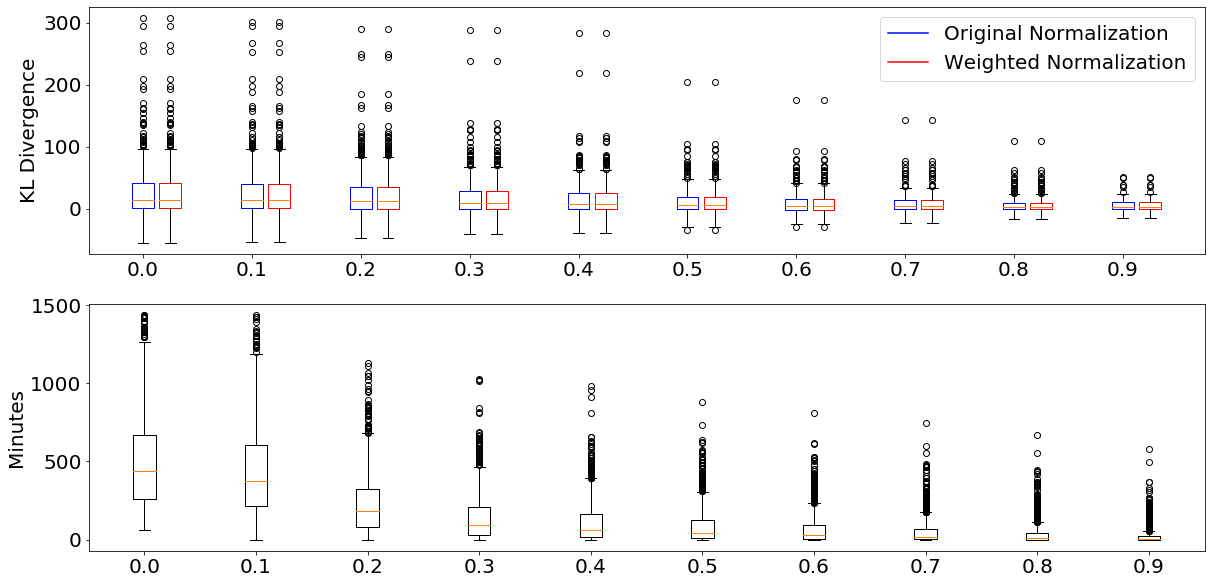

In [7]:
def KL(P,Q):
    """ Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0. """
    epsilon = 0.00001

     # You may want to instead make copies to avoid changing the np arrays.
    P = P+epsilon
    Q = Q+epsilon

    divergence = np.sum(P*np.log(P/Q))
    return divergence
from sklearn.metrics import r2_score
import pickle
import numpy as np
directory = '../../cc3/rice_data/ecg_ppg_25_left4/'
all_scores_1 = []
all_scores_2 = []
all_yields = []
for k in np.arange(0,1,.1):
    all_scores = []
    yields = []
    for data1 in data_col:
        for i,data in data1.groupby('hand',as_index=False): 
            data_days = [df[['stress_likelihood_ecg',
                             'stress_likelihood_ppg',
                             'stress_likelihood_ppg_qual',
                             'quality_mag']] for i,df in data.groupby(['user','day'],as_index=False) if df.shape[0]>0]
            yields.extend([df[df.quality_mag>=k]['stress_likelihood_ppg'].dropna().shape[0] for df in data_days])
            data_days = [a[a.quality_mag>=k].dropna() for a in data_days if a[a.quality_mag>=k].dropna().shape[0]>60]
            try:
                scores = [np.array([KL(df['stress_likelihood_ecg'],df['stress_likelihood_ppg']), \
                                KL(df['stress_likelihood_ecg'],df['stress_likelihood_ppg_qual'])]) for df in data_days]
            except:
                scores = [np.zeros(0,2)]
            all_scores.extend(scores)
    all_yields.append(np.array(yields))
    all_scores = np.array(all_scores)
    all_scores_1.append(list(all_scores[:,0]))
    all_scores_2.append(list(all_scores[:,1]))        

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20})
fig,ax1 = plt.subplots(2,1,figsize=(20,10))
ax1[1].boxplot(all_yields, positions = np.array(range(0,10,1)), widths = 0.2)
ax1[1].set_xticklabels([str(np.round(k*100)/100) for k in np.arange(0,1,.1)])
ax1[1].set_xticks(range(0,10,1))
ax1[1].set_ylabel('Minutes')
ax = ax1[0]
bp = ax.boxplot(all_scores_1, positions = np.array(range(1,11,1)), widths = 0.2)
for i in range(10):
    plt.setp(bp['boxes'][i], color='blue')
bp = ax.boxplot(all_scores_2, positions = np.array(range(1,11,1))+.25, widths = 0.2)
for i in range(10):
    plt.setp(bp['boxes'][i], color='red')
ax.set_xticklabels([str(np.round(k*100)/100) for k in np.arange(0,1,.1)])
ax.set_xticks(range(1,11,1))
ax.set_ylabel('KL Divergence')
hB, = plt.plot([1,1],'b-')
hR, = plt.plot([1,1],'r-')
ax.legend((hB, hR),('Original Normalization', 'Weighted Normalization'))
hB.set_visible(False)
hR.set_visible(False)
plt.show()

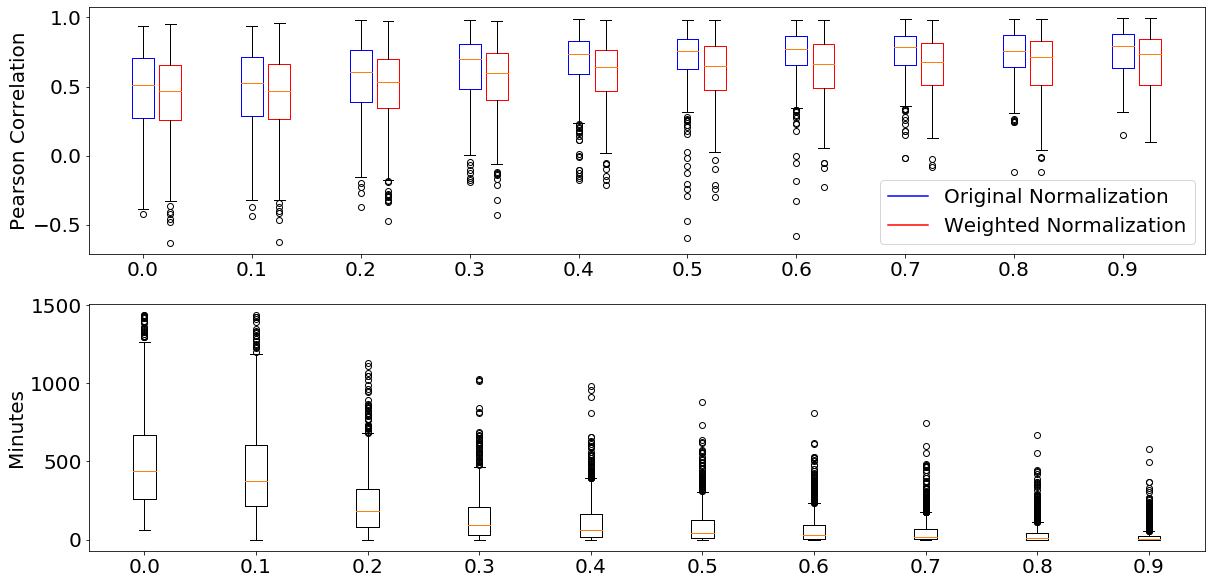

In [10]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import pickle
import numpy as np
import pandas as pd
from pandas.core.window import _flex_binary_moment, _Rolling_and_Expanding
import matplotlib.pyplot as plt

def weighted_mean(self, weights, **kwargs):
    weights = self._shallow_copy(weights)
    window = self._get_window(weights)

    def _get_weighted_mean(X, Y):
        X = X.astype('float64')
        Y = Y.astype('float64')
        sum_f = lambda x: x.rolling(window, self.min_periods, center=self.center).sum(**kwargs)
        return sum_f(X * Y) / sum_f(Y)

    return _flex_binary_moment(self._selected_obj, weights._selected_obj,
                               _get_weighted_mean, pairwise=True)

_Rolling_and_Expanding.weighted_mean = weighted_mean

# directory = '../../cc3/rice_data/ecg_ppg_25_left4/'
all_scores_1 = []
all_scores_2 = []
all_yields = []
for k in np.arange(0,1,.1):
    all_scores = []
    yields = []
    for data1 in data_col:
        for i,data in data1.groupby('hand',as_index=False):
            data = data.sort_values('time').reset_index(drop=True)
            data['stress_likelihood_ppg_qual'] = data['stress_likelihood_ppg'].rolling(window = 11).weighted_mean(data['quality_mag'])
            data_days = [df[['stress_likelihood_ecg',
                             'stress_likelihood_ppg',
                             'stress_likelihood_ppg_qual',
                             'quality_mag']] for i,df in data.groupby(['user','day'],as_index=False) if df.shape[0]>0]
            yields.extend([df[df.quality_mag>=k]['stress_likelihood_ppg'].dropna().shape[0] for df in data_days])
            data_days = [a[a.quality_mag>=k].dropna() for a in data_days if a[a.quality_mag>=k].dropna().shape[0]>60]
            try:
                scores = [np.array([pearsonr(df['stress_likelihood_ecg'],df['stress_likelihood_ppg'])[0], \
                                pearsonr(df['stress_likelihood_ecg'],df['stress_likelihood_ppg_qual'])[0]]) for df in data_days]
            except:
                scores = [np.zeros(0,2)]
            all_scores.extend(scores)
    all_yields.append(np.array(yields))
    all_scores = np.array(all_scores)
    all_scores_1.append(list(all_scores[:,0]))
    all_scores_2.append(list(all_scores[:,1]))        

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20})
fig,ax1 = plt.subplots(2,1,figsize=(20,10))
ax1[1].boxplot(all_yields, positions = np.array(range(0,10,1)), widths = 0.2)
ax1[1].set_xticklabels([str(np.round(k*100)/100) for k in np.arange(0,1,.1)])
ax1[1].set_xticks(range(0,10,1))
ax1[1].set_ylabel('Minutes')
ax = ax1[0]
bp = ax.boxplot(all_scores_1, positions = np.array(range(1,11,1)), widths = 0.2)
for i in range(10):
    plt.setp(bp['boxes'][i], color='blue')
bp = ax.boxplot(all_scores_2, positions = np.array(range(1,11,1))+.25, widths = 0.2)
for i in range(10):
    plt.setp(bp['boxes'][i], color='red')
ax.set_xticklabels([str(np.round(k*100)/100) for k in np.arange(0,1,.1)])
ax.set_xticks(range(1,11,1))
ax.set_ylabel('Pearson Correlation')
hB, = plt.plot([1,1],'b-')
hR, = plt.plot([1,1],'r-')
ax.legend((hB, hR),('Original Normalization', 'Weighted Normalization'))
hB.set_visible(False)
hR.set_visible(False)
plt.show()

In [ ]:
all_yields

In [ ]:
data_col[0].head()

In [ ]:
from fireTS.models import NARX, DirectAutoRegressor